<a href="https://colab.research.google.com/github/ollihansen90/zeugs/blob/main/Kopie_von_Kopie_von_MDL_Exercise2_Registration_Bonus_Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u>M</u>edical <u>D</u>eep <u>L</u>earning
## Exercise 2: Image Registration - Bonus Task

## Preparation

In [4]:
# download dataset
!wget https://cloud.imi.uni-luebeck.de/s/5ZojnpTRxfLCmYd/download -O mdl_exercise3_multimodal_reg.pth


--2024-05-26 18:22:20--  https://cloud.imi.uni-luebeck.de/s/5ZojnpTRxfLCmYd/download
Resolving cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)... 141.83.20.118
Connecting to cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)|141.83.20.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39324179 (38M) [application/octet-stream]
Saving to: ‘mdl_exercise3_multimodal_reg.pth’

mdl_exercise3_multi 100%[===================>]  37.50M  17.3MB/s    in 2.2s    

2024-05-26 18:22:23 (17.3 MB/s) - ‘mdl_exercise3_multimodal_reg.pth’ saved [39324179/39324179]



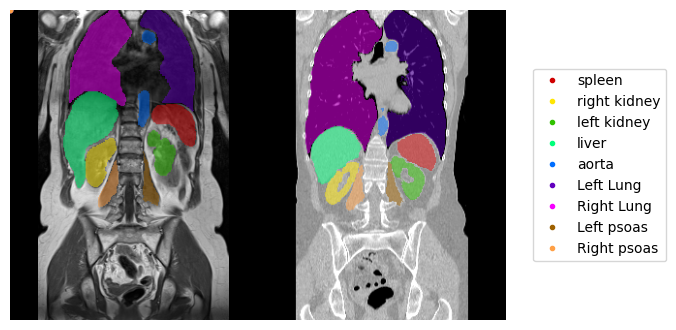

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
def gpu_usage():
    print('gpu usage (current/max): {:.2f} / {:.2f} GB'.format(torch.cuda.memory_allocated()*1e-9, torch.cuda.max_memory_allocated()*1e-9))

#load data which contains 8 pairs of 2D MR and CT slices with anatomical labels.
#The images are stored in the tensors, ct_img_all, mr_seg_all, etc.
#Please note that for the first task, there exists a pre-registered variant called ct_img_all_reg ..
data = torch.load('mdl_exercise3_multimodal_reg.pth')
locals().update(data)
### overlaySegment: returns RGB-overlay of given image and segmentation
def overlaySegment(gray1,segs1,colors):
    H, W = segs1.squeeze().size()
    C = colors.shape[0]
    segs1_onehot = torch.zeros(size=(C,H,W)).to(segs1.device).scatter_(0, segs1.view(1,H,W), 1).detach()
    seg_color = torch.mm(segs1_onehot.view(C,-1).t(),colors).view(H,W,3)
    alpha = torch.clamp(1.0 - 0.5*(segs1_onehot[0,:,:]==0).float(),0,1.0)
    overlay = (gray1*alpha).unsqueeze(2) + seg_color*(1.0-alpha).unsqueeze(2)
    return overlay

## visualise two input scans
rgb = overlaySegment(
            torch.clamp(mr_img_all[3,0].permute(1,0).flip(0,1),0,700)/700,
            mr_seg_all[3,0].permute(1,0).flip(0,1),
            cdata.view(-1,3)/255
        )
rgb2 = overlaySegment(
            torch.clamp(ct_img_all[3,0].permute(1,0).flip(0,1)+800,0,1200)/1200,
            ct_seg_all[3,0].permute(1,0).flip(0,1),
            cdata.view(-1,3)/255
        )

plt.imshow(torch.cat((rgb,rgb2),1))
plt.axis('off')
for i in range(1,10):
    plt.plot(0,0,'.',color=cdata[i].numpy()/255,label=organs_wb[i-1])
    plt.legend(bbox_to_anchor=(1.04,.5), loc='center left' )
plt.show()

In [6]:
# utility functions to display a displacement field and compute the Dice overlap
from matplotlib import cm
from matplotlib import colors as mcolors
import numpy as np
def showFlow(def_x):
    x = def_x.squeeze().numpy()[0,:,:]
    y = def_x.squeeze().numpy()[1,:,:]
    #show flow map for numpy
    H, W = x.shape
    rho = np.sqrt(x*x+y*y)
    theta = np.arctan2(x,-y)
    theta2 = (-theta+np.pi)/(2.0*np.pi);
    rho = np.clip(rho/np.percentile(rho, 99),0,1)
    hsv = np.stack((theta2,rho,np.ones((H,W))),axis=2)
    rgb = mcolors.hsv_to_rgb(hsv)
    return rgb

def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice


## Bonus 1: Modality Invariant Neighbourhood Descriptor (MIND) (5 points)
Even though mutual information yields good results to estimate global translations it may cause problems when used to supervise a deformable registration network. Here, we want to implement an extended version of the Modality Invariant Neighbourhood Descriptor (MIND) as metric for learning-based deformable multimodal registration. See https://iplab.dmi.unict.it/miss14/MISS2014-ReadingGroup00-All-Paper.pdf for details if interested.

![MIND](https://cloud.imi.uni-luebeck.de/s/do5qBKsz6CSaa3S/download)

MIND relies on a pattern of self-similarities in each modality (calculated using patch-distances in the neighbourhood) that are normalised by their local contrast and thus directly comparable across domains.

The algorithm can be realised in few steps:
- 1) definition of the spatial offset layout of the patch-distances (these are two 1x64x1x2 tensors that are given) and a regular grid with stride 4. It is important that the offset layout remains the same once it has been created.


- 2) the extraction of a local 5x5 patches (padding=2) for every pixel using unfold, the output tensor "img_patch" should be reshaped to contain a channel dimension of C=25

- 3) the computation of patch-SSDs that define the self-similarities; herefore the grid_sample command has to be applied twice to img_patch using the addition of global (grid) and local (mind_layout1/2) coordinates. Both tensors have to be subtracted, their result squared and summed over the patch-dimension (dim=1). This yields "mind_patch" of shape 1 x 64 x 5120 (H//4 x W//4).

- 4) afterwards the min value along dim=1 should be subtracted and the result should be devided by the standard deviation along dim=1 (avoid division by zero with small positive constant)

- 5) finally the result should be negated, exponentiated and reshaped to 1 x 64 x H//4 x W//4 and returned

In [7]:
for k, v in (data.items()):
    if type(v)==list:
        print(k, len(v), type(v))
    else:
        print(k, v.shape, type(v))

mr_img_all torch.Size([8, 1, 256, 320]) <class 'torch.Tensor'>
mr_seg_all torch.Size([8, 1, 256, 320]) <class 'torch.Tensor'>
ct_img_all torch.Size([8, 1, 256, 320]) <class 'torch.Tensor'>
ct_seg_all torch.Size([8, 1, 256, 320]) <class 'torch.Tensor'>
ct_img_all_reg torch.Size([8, 1, 256, 320]) <class 'torch.Tensor'>
ct_seg_all_reg torch.Size([8, 1, 256, 320]) <class 'torch.Tensor'>
organs_wb 9 <class 'list'>
cdata torch.Size([27, 3]) <class 'torch.Tensor'>


In [12]:
# Generating smaller fixed length offsets for 64 MIND-SSC-like features
torch.manual_seed(0)
mind_layout1 = torch.randn(1, 64, 1, 2)#.cuda()
mind_layout2 = torch.randn(1, 64, 1, 2)#.cuda()
mind_layout2[:, :32, :, :] = 0
fixed_length = 0.05
mind_length = torch.sqrt(torch.sum((mind_layout1 - mind_layout2) ** 2, 3, keepdim=True))
mind_layout1 /= mind_length / fixed_length
mind_layout2 /= mind_length / fixed_length

# TODO: Create the regular grid for the MIND features
N, C, H, W = ct_img_all[:1].shape
grid = torch.stack(torch.meshgrid(torch.arange(0, H, 4), torch.arange(0, W, 4)), dim=-1).float()#.cuda()
print("Grid shape", grid.shape)

def MIND2D(image, mind_layout1, mind_layout2, grid):
    # Extract local 5x5 patches
    img_patch = F.unfold(image, kernel_size=5, padding=2, stride=4).view(-1, 25, H//4, W//4)
    print("patches", img_patch.shape)
    print(image.shape)

    # Compute patch-SSDs
    print(grid.shape, mind_layout1.shape)
    local_coords1 = grid + mind_layout1
    local_coords2 = grid + mind_layout2
    global_coords = grid
    print(local_coords1.shape, local_coords2.shape, global_coords.shape)

    patches_local_1 = F.grid_sample(img_patch, local_coords1, mode="bilinear", align_corners=True)
    patches_local_2 = F.grid_sample(img_patch, local_coords2, mode="bilinear", align_corners=True)
    patches_global = img_patch.clone() #F.grid_sample(img_patch, global_coords, mode="bilinear", align_corners=True)

    patch_ssds = torch.sum((patches_local_1-patches_local_2)**2, dim=1)

    # the computation of patch-SSDs that define the self-similarities; herefore the grid_sample command has to be applied twice to
    # img_patch using the addition of global (grid) and local (mind_layout1/2) coordinates. Both tensors have to be subtracted, their
    # result squared and summed over the patch-dimension (dim=1). This yields "mind_patch" of shape 1 x 64 x 5120 (H//4 x W//4).
    #patch_ssds = torch.sum((F.grid_sample(img_patch, local_coords, mode='bilinear', align_corners=True) - F.grid_sample(img_patch, global_coords, mode='bilinear', align_corners=True)) ** 2, dim=1)
    #patch_ssds = None
    print(f'patch ssd: {patch_ssds.shape}')

    # Normalize patch-SSDs
    patch_ssds -= torch.min(patch_ssds, dim=1, keepdim=True)[0]
    patch_ssds /= torch.std(patch_ssds, dim=1, keepdim=True) + 1e-5

    # Apply exponential and reshape
    mind_patch = torch.exp(-patch_ssds).view(1, H//4, W//4)
    print(mind_patch.shape)

    return mind_patch

mind_patch = MIND2D(ct_img_all[:1], mind_layout1, mind_layout2, grid)
#mind_patch = MIND2D(ct_img_all[:1].cuda(), mind_layout1, mind_layout2, grid)

Grid shape torch.Size([64, 80, 2])
patches torch.Size([1, 25, 64, 80])
torch.Size([1, 1, 256, 320])
torch.Size([64, 80, 2]) torch.Size([1, 64, 1, 2])
torch.Size([1, 64, 80, 2]) torch.Size([1, 64, 80, 2]) torch.Size([64, 80, 2])
patch ssd: torch.Size([1, 64, 80])
torch.Size([1, 64, 80])


In [52]:
test = torch.arange(10)[:,None] + 2*torch.arange(10)
print(test)
test_u = F.unfold(test.unsqueeze(0).float(), kernel_size=5, stride=5)
print(test_u)

tensor([[ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18],
        [ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19],
        [ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20],
        [ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21],
        [ 4,  6,  8, 10, 12, 14, 16, 18, 20, 22],
        [ 5,  7,  9, 11, 13, 15, 17, 19, 21, 23],
        [ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24],
        [ 7,  9, 11, 13, 15, 17, 19, 21, 23, 25],
        [ 8, 10, 12, 14, 16, 18, 20, 22, 24, 26],
        [ 9, 11, 13, 15, 17, 19, 21, 23, 25, 27]])
tensor([[ 0., 10.,  5., 15.],
        [ 2., 12.,  7., 17.],
        [ 4., 14.,  9., 19.],
        [ 6., 16., 11., 21.],
        [ 8., 18., 13., 23.],
        [ 1., 11.,  6., 16.],
        [ 3., 13.,  8., 18.],
        [ 5., 15., 10., 20.],
        [ 7., 17., 12., 22.],
        [ 9., 19., 14., 24.],
        [ 2., 12.,  7., 17.],
        [ 4., 14.,  9., 19.],
        [ 6., 16., 11., 21.],
        [ 8., 18., 13., 23.],
        [10., 20., 15., 25.],
        [ 3., 13.,  8., 18.],
        [ 5., 15., 

In [2]:
print(64*64*80)

327680


## Bonus 2: Learning global + local deformable multimodal registration (5 points)

Now, we are ready to complete the exercise by replacing the MI-loss function with MIND and extending our global only to a combined global and local registration network. We will register two scans by first estimating their translation (with a very large capture range of 19 pixels on the coarse grid), then warp/shift the moving CT image and its corresponding labels; and second estimate a local nonlinear deformation using a smaller capture range of 13 pixels but the same feature network and correlation layer.

You can re-use many elements of the previous task and again use a standard training loop with 1000 Adam-iterations (lr=0.001). The global translation is estimated exactly as before, but now
- 1) we compute another feature tensor based on the shifted CT image > "ct_feat2" (We again call the forward path of our feature net with fixed MR and shifted/translated CT image).

- 2) this is used together with "mr_feat" as input to the correlationLayer with disp_range = 13. Now we want to estimate a deformable transformation.

- 3) to regularise the field that the correlationLayer estimates, we apply two avg_pool2d with kernel=5, stride=1 and padding=2 and interpolate the result by a scale_factor=8 with mode='bilinear'. Afterwards the displacements need to be converted into pytorch's defintion using
```smooth_disp = (smooth_field/torch.tensor([(H-1)/2,(W-1)/2]).cuda().view(1,2,1,1)).flip(1)```

- 4) we use grid_sample with "ct_mind" as first and the addition of previous translation grid "t_grid" and smooth_disp to warp the MIND features (note that the stride of MIND is 4).

- 5) we use ```nn.SmoothL1Loss(beta=.25)``` https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html?highlight=nn%20smoothl1loss#torch.nn.SmoothL1Loss as loss function between "mr_mind" and the warped ct_mind

- 6) complete the training loop with loss.backward(), optimizer.step() and optimizer.zero_grad()

The model should train without approx. 1 minute and yield an average Dice overlap of 68-71% up from just 36% initial alignment. We provided some functions to visualise the output

In [ ]:
def correlationLayer(mr_feat,ct_feat,disp_range=11,smooth_kernel=7,alpha_softmax=-150):
    half_range = (disp_range-1)//2
    _,num_feat,H_4,W_4 = mr_feat.shape

    ##given: the relative pixel offsets of the correlation layer can be obtained with affine_grid
    # in this case the stride of features is 4, we hence have to multiply the range by 4
    displacement_mesh = F.affine_grid(4*half_range*torch.eye(2,3).cuda().unsqueeze(0),(1,1,disp_range,disp_range),align_corners=True).permute(3,2,1,0).reshape(1,2,disp_range**2,1,1)

    ##TODO implement nn.Unfold for correlation layer that uses a window disp_range x disp_range
    # and a stride=1 with padding=half_range
    unfold = nn.Unfold(kernel_size=(disp_range, disp_range), stride=1, padding=half_range)

    #extract 'unfolded' patches from CT=moving scan (keeping MR as is) and view both tensors as
    # 1 x num_feat x disp_range**2 x -1
    # after you can compute the distance between both features tensors by taking their absolute difference
    # and averaging over the feature dimension (dim=1)
    unfolded = unfold(ct_feat).view(1, num_feat, disp_range ** 2, -1)
    mr_feat = mr_feat.view(1, num_feat,1, -1)
    correlation = torch.mean(torch.abs(mr_feat - unfolded), dim=1)

    # reshape the correlation tensor to the shape 1 x disp_range**2 x H_4 x W_4
    # apply two avg_pool2d operators with smooth_kernel (don't forget padding) and a stride=2 for the second one¶#
    correlation = correlation.reshape(1, disp_range ** 2, H_4, W_4)
    correlation_smooth = F.avg_pool2d(F.avg_pool2d(correlation, smooth_kernel, stride=2, padding=smooth_kernel//2),
                                      smooth_kernel, stride=2, padding=smooth_kernel//2)

    # finally the displacement field can be obtained by
    # 1) multiplying the correlation with a negative alpha,
    # 2) applying a softmax on dim=1 and expanding the tensor with unsqueeze(1)
    # 3) multiplying the resulting displacement probabilities with displacement_mesh and
    # 4) summing over dim=2 (this dimension comprises disp_range**2 values each)
    probabilities = F.softmax(correlation_smooth*(alpha_softmax), dim=1).unsqueeze(1)
    field = torch.sum(probabilities * displacement_mesh, dim=2)
    return field

In [ ]:
def translateMovingImg(img_in, label_in):
  rand_shift = torch.randint(-15, 16, (2,))

  # Extract sx and sy values
  sx, sy = rand_shift[0].item(), rand_shift[1].item()

  img_out = torch.roll(img_in, shifts=(sx, sy), dims=(2, 3))
  label_out = torch.roll(label_in, shifts=(sx, sy), dims=(2, 3))

  return img_out, label_out

ct_img, ct_label = translateMovingImg(ct_img_all_reg[5:6,0:1].cuda()/500, F.one_hot(ct_seg_all_reg[5:6,0].cuda(),10).permute(0,3,1,2).float())
print(ct_img.shape, ct_label.shape)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# todo Feature net
#from torchinfo import summary
class FeatureNet(nn.Module):
    def __init__(self):

        super(FeatureNet, self).__init__()
        num_feat = 64
        self.ct_net = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2),
            nn.InstanceNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, 3, stride=2),
            nn.InstanceNorm2d(32),
            nn.ReLU()
        )
        self.mr_net = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2),
            nn.InstanceNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, 3, stride=2),
            nn.InstanceNorm2d(32),
            nn.ReLU()
        )
        self.shared_net = nn.Sequential(
            nn.Conv2d(32, 32, 3, stride=1),
            nn.InstanceNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, stride=1),
            nn.InstanceNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, num_feat, 3, stride=1),
            nn.InstanceNorm2d(num_feat),
            nn.Sigmoid()
        )


    def forward(self, mr_img, ct_img):

        mr_feat = self.shared_net(self.mr_net(mr_img))
        ct_feat = self.shared_net(self.ct_net(ct_img))

        return mr_feat, ct_feat

In [ ]:
## setup given up until the image/label samples are pre-processed
import time
from tqdm.autonotebook import tqdm
H = 256; W = 320

n_epochs = 1000

net = FeatureNet()
net.cuda()

d0_all = torch.zeros(8,9)
d1_all = torch.zeros(8,9)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
run_loss = torch.zeros(n_epochs)
run_dice = torch.zeros(n_epochs)

t0 = time.time()

for i in tqdm(range(n_epochs)):
    if((i<(n_epochs-8))&(i>8)):
        nu = torch.randperm(8)[0]
    else:
        nu = i%8

    mr_img = (mr_img_all[nu:nu+1,0:1].cuda()-200)/250
    ct_img = ct_img_all[nu:nu+1,0:1].cuda()/500
    mr_label = F.one_hot(mr_seg_all[nu:nu+1,0].cuda(),10).permute(0,3,1,2).float()
    ct_label = F.one_hot(ct_seg_all[nu:nu+1,0].cuda(),10).permute(0,3,1,2).float()

    # TODO call feature net, call MIND2D with no_grad(), call correlationLayer (using a disparity range of 19)
    # and estimate translation
    # Please store MIND features for MRI and CT in mr_mind and ct_mind respectively

    # Call FeatureNet
    mr_feat,ct_feat = net(mr_img,ct_img)

    # Call MIND2D
    with torch.no_grad():
      mr_mind = MIND2D(mr_img, mind_layout1, mind_layout2, grid)
      ct_mind = MIND2D(ct_img, mind_layout1, mind_layout2, grid)

    # Call correlationLayer
    disp_range = 19
    field = correlationLayer(mr_feat,ct_feat,disp_range).cuda()

    ct_img, ct_label = translateMovingImg(ct_img, ct_label)


    t_xy = (field[0:1,:,4:-4,4:-4].mean(-1).mean(-1)/torch.tensor([(H-1)/2,(W-1)/2]).cuda().view(1,2)).flip(1)
    t_grid = F.affine_grid(torch.cat((torch.eye(2).cuda(),t_xy.t()),1).unsqueeze(0),(1,1,H,W))

    # todo: warp the moving image (CT) and label map (hint: use grid_sample)
    ct_img2 = F.grid_sample(ct_img, t_grid, align_corners=True).cuda()
    ct_label2 = F.grid_sample(ct_label, t_grid, align_corners=True).cuda()

    # TODO call feature net again and MIND2D for shifted CT, call correlationLayer and smooth/interpolate field
    #convert field to pytorch displacements, warp image, label (take care to include t_grid) and MIND (stride=4!)
    #call SmoothL1Loss (x4), and backward, step, zero_grad (disparity range: 13).
    # Please store the MIND features in ct_mind2

    # to regularise the field that the correlationLayer estimates, we apply two avg_pool2d with kernel=5, stride=1
    # and padding=2 and interpolate the result by a scale_factor=8 with mode='bilinear'. Afterwards the displacements
    # need to be converted into pytorch's defintion using smooth_disp = (smooth_field/torch.tensor([(H-1)/2,(W-1)/2]).cuda().view(1,2,1,1)).flip(1)

    # Call FeatureNet
    mr_feat2,ct_feat2 = net(mr_img,ct_img) # oder hier mr_mind und ct_mind rein?

    # Call MIND2D
    with torch.no_grad():
      ct_mind2 = MIND2D(ct_img2, mind_layout1, mind_layout2, grid)


    field = correlationLayer(mr_feat,ct_feat,13).cuda()


    smooth_field = F.interpolate(F.avg_pool2d(F.avg_pool2d(field, kernel_size=5, stride=1, padding=2), kernel_size=5, stride=1, padding=2), scale_factor=8)

    smooth_disp = (smooth_field/torch.tensor([(H-1)/2,(W-1)/2]).cuda().view(1,2,1,1)).flip(1)

    # TODO
    grid0 = F.affine_grid(torch.eye(2,3).cuda().unsqueeze(0),(1,1,H,W))
    warped_label = F.grid_sample(ct_label2, t_grid, align_corners=True).cuda()
    warped_img = F.grid_sample(ct_img2, t_grid, align_corners=True).cuda()
    warped_mind = F.grid_sample(ct_mind2, t_grid, align_corners=True).cuda()

    loss = nn.SmoothL1Loss(beta=.25)
    output = loss(mr_mind, warped_mind)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    run_loss[i] = loss.item()

    ## end TODO

    #given: evaluation, logging
    d1 = dice_coeff(mr_label.argmax(1),warped_label.argmax(1).data,10).cpu()

    run_dice[i] = d1.mean()

    d1_all[nu] = d1
    if(i<=7):
        d0 = dice_coeff(mr_label.argmax(1),ct_label.argmax(1),10).cpu()
        d0_all[nu] = d0


    if(i%50==49):
        str1 = f"iter: {i}, loss: {'%0.3f'%run_loss[i-20:i-1].mean()}, init Dice: {'%0.2f'%(100*d0_all.mean())}, current Dice: {'%0.3f'%(100*run_dice[i-20:i-1].mean())}, runtime: {'%0.3f'%(time.time()-t0)} sec"
        tqdm.write(str1)



#given visualisation of overlay before after
gpu_usage()
rgb = overlaySegment(torch.clamp(mr_img.squeeze().permute(1,0).cpu().flip(0,1)*250+250,0,700)/700,ct_label.argmax(1).squeeze().cpu().permute(1,0).flip(0,1),cdata.view(-1,3)/255)
rgb2 = overlaySegment(torch.clamp(mr_img.squeeze().permute(1,0).cpu().flip(0,1)*250+250,0,700)/700,warped_label.argmax(1).data.squeeze().cpu().permute(1,0).flip(0,1),cdata.view(-1,3)/255)

plt.imshow(torch.cat((rgb,rgb2),1))
plt.axis('off')
for i in range(1,10):
    plt.plot(0,0,'.',color=cdata[i].numpy()/255,label=organs_wb[i-1])
    plt.legend(bbox_to_anchor=(1.04,.5), loc='center left' )
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

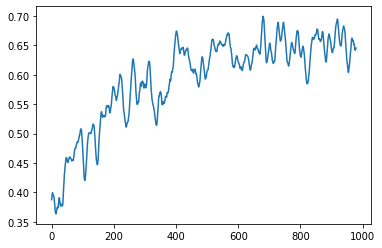

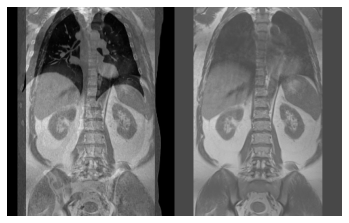

gpu usage (current/max): 0.03 / 2.07 GB
Dice before 36.29 and after 64.97


In [ ]:
plt.plot(F.avg_pool1d(F.avg_pool1d(run_dice.view(1,1,-1),11,stride=1),11,stride=1).squeeze())
plt.show()
overlay_before = torch.clamp(mr_img_all[nu,0].data.permute(1,0).flip(0,1),0,700)/300+\
           torch.clamp(ct_img_all[nu,0].data.permute(1,0).flip(0,1)+800,0,1200)/1200

overlay_after = torch.clamp(mr_img_all[nu,0].data.permute(1,0).flip(0,1),0,700)/300+\
           torch.clamp(warped_img.cpu().data.squeeze().permute(1,0).flip(0,1)*500+800,0,1200)/1200


plt.imshow(torch.cat((overlay_before,overlay_after),1),'gray')
plt.axis('off')
plt.show()

gpu_usage()
print('Dice before','%0.2f'%(100*d0_all.mean()),'and after','%0.2f'%(100*d1_all.mean()))

In [ ]:
gpu_usage()
print(d0_all.mean(),d1_all.mean())

gpu usage (current/max): 0.03 / 2.07 GB
tensor(0.3629) tensor(0.6497)


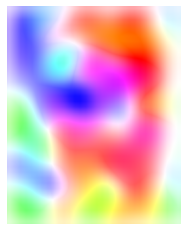

In [ ]:
rgb = showFlow(smooth_disp.data.cpu())
plt.imshow(np.flip(rgb.transpose(1,0,2),0))
plt.axis('off')
plt.show()

## Theoretical Question (4 points)
### **Question**: Explain the difference between the task of affine and deformable registration, especially regarding their applicability in medical imaging. How do deep learning networks for those tasks differ?

The answer should be between 300 and 600 words long and should be submitted to moodle as text.
### **Answer**:

Affine registration is a global registration approach. It only uses a combination of affine transformations like translation, rotation, scaling and shearing to register two images. Affine registration is less flexible and suitable for scenarios where shape preservation is expected, because every transformation does changes in the hole image. Due to that it does well in registering the overall structure of one image to another, but it does not necessarily capture differences in smaller details.

For this kind of task deformable image registration works better. Deformable image registration is the process of finding correspondence between images that are not linked by simple affine transformations. Deformable image registration registers the images localy. It uses local non-linear transfrmations. Due to this this approach is more flexible. It identifies the spatial correspondence in order to minimize the differences between two or among multiple sets of images. Through this it is possible to register shapes of tumors, orgns etc. exactly.

Affine reghistration is way more simple. It is useful when the anatomical structures are expected to maintain a consistent shape and size but may be differently oriented or positioned. For example the same brain scan from different time points. The problem here is, that minimal movements of the patient leads to more difficult differences in the images. If a precise alignment of detailed anatomical structures is essential, then deformable image registration is the method to use (for example tracking of tumor growth or ingrating functional imaging data (like PET scans) with structural data (like MRI) to correlate metabolic activity with anatomical landmarks).

Deep learning networks for affine registration typically employ convolutional neural networks (CNNs) to predict the parameters of the affine transformation. These networks take a pair of images as input and output the transformation matrix. The architecture involves:
Feature extraction: Using CNN layers to extract relevant features from the input images.
Parameter prediction: A regression layer predicts the affine transformation parameters.
Transformation application: The predicted parameters are used to warp one image to align with the other.

Deep learning networks for deformable registration are generally more complex and make use of architectures that can model spatial deformations at a finer grid. The architecture involves:
Feature extraction: Similar to affine registration, CNN layers are used to extract features.
Displacement field prediction: Instead of predicting a single transformation matrix, the network outputs a dense displacement field indicating the required pixel-wise shifts.
Warping layer: The displacement field is applied to deform the moving image to align with the fixed image.

